In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import guitarpro

import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from src.models.markov_chain import MarkovChain
from src.parse_gp import drop_rests_from_drum_track, get_notes_and_durations
from src.save_midi import save_notes_and_durations, save_notes

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = [], []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        tab_notes, tab_durations = get_notes_and_durations(tab, track_name, True)
        notes += tab_notes
        durations += tab_durations

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

<BarContainer object of 526 artists>

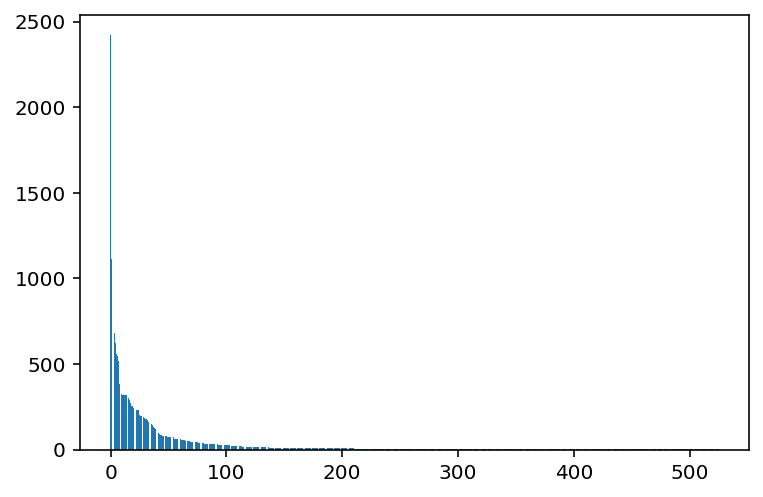

In [4]:
note_counts = Counter(notes)
df = pd.DataFrame(note_counts.items(), columns=['note', 'cnt']).sort_values('cnt', ascending=False)
plt.bar(range(df.shape[0]), df.cnt)

In [5]:
limit = 200

In [6]:
note_to_use = df.iloc[:limit].note.values

In [7]:
notes_corr, durations_corr = [], []
for note, dur in zip(notes, durations):
    if note in note_to_use:
        notes_corr.append(note)
        durations_corr.append(dur)

In [8]:
note_dictionary = {note: i for i, note in enumerate(note_to_use)}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes_corr]
notes_to_int[:10]

[22, 3, 3, 0, 3, 3, 3, 5, 3, 0]

In [9]:
duration_dictionary = {dur: i for i, dur in enumerate(set(durations_corr))}
inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
durations_to_int = [duration_dictionary[dur] for dur in durations_corr]
durations_to_int[:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [10]:
notes[:10]

['C#3.F#3.', 'F#3.', 'F#3.', '', 'F#3.', 'F#3.', 'F#3.', 'G3.', 'F#3.', '']

In [11]:
durations[:10]

[1.0, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]

In [12]:
markov_notes = MarkovChain()
markov_notes.fit_partial(notes_to_int)

In [13]:
markov_durations = MarkovChain()
markov_durations.fit_partial(durations_to_int)

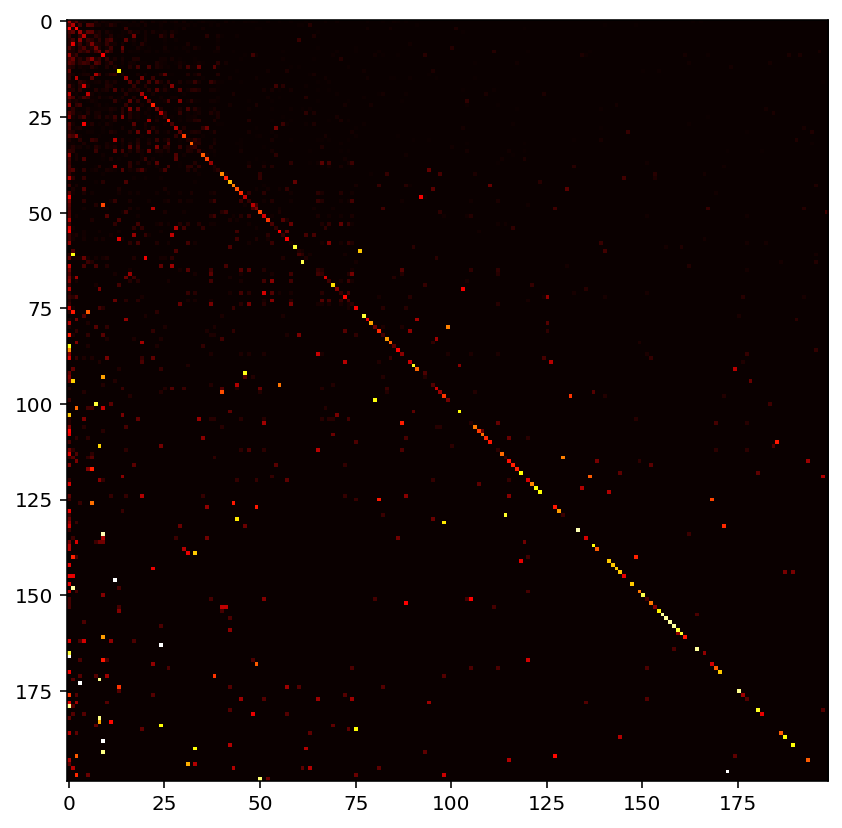

In [14]:
note_matrix = markov_notes.heatmap_of_transitions()

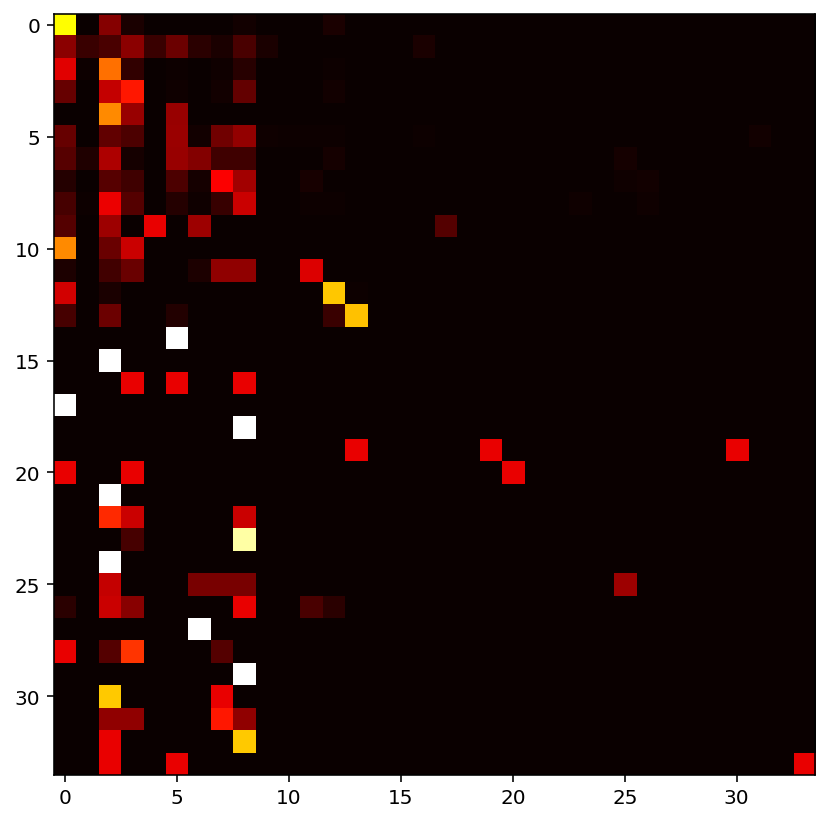

In [15]:
duration_matrix = markov_durations.heatmap_of_transitions()

In [16]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [18]:
temperatures = [0.0, 0.5, 0.9]

for temperature in temperatures:
    generated_notes = [note_dictionary['B1.']]
#     generated_notes = [note_dictionary['46.36.']]
    generated_durations = [duration_dictionary[1/16]]
    for i in range(100):
        probas = [markov_notes.predict_proba_state_transition(generated_notes[i], note_dictionary[x]) + 1e-6 for x in note_dictionary]
        generated_notes.append(sample(probas, temperature))

        probas = [markov_durations.predict_proba_state_transition(generated_durations[i], duration_dictionary[x]) + 1e-6 for x in duration_dictionary]
        generated_durations.append(sample(probas, temperature))
    
    generated = [[inv_note_dictionary[x] for x in generated_notes], [inv_dur_dictionary[x] for x in generated_durations]]
    save_notes_and_durations(generated, f'output/markov/markov_output_{temperature}')